## [Description](#Description_)
## [Research](#Research_)
## [Imports](#Imports_)
## [Globals](#Globals_)
## [Utils](#Utils_)
- ### [Markdown](#Markdown_)
- ### [Yadisk](#Yadisk_)
- ### [Cli](#Cli_)
- ### [Other](#Other_)
## [Setup](#Setup_)
## [Data](#Data_)
## [Metrics](#Metrics_)
## [Model](#Model_)
- ### [Popular](#Popular_)
- ### [SVD](#SVD_)
- ### [Item2Item](#Item2Item_)
- ### [ALS](#ALS_)
- ### [Implicit ALS](#Implicit_ALS_)
## [Training](#Training_)
- ### [Hyperparameter sweeps](#Hyperparameter_sweeps_)
- ### [SVD sweep](#SVD_sweep_)
- ### [ALS sweep](#ALS_sweep_)
- ### [Implicit ALS sweep](#Implicit_ALS_sweep_)
## [Results](#Results_)
- ### [Test metrics](#Test_metrics_)
- ### [Recommendations](#Recommendations_)

## Description <span id=Description_></span>

# План домашней работы
1. Реализовать алгоритмы **item2item**, **ALS**, **IALS** (2 балл за каждый)
2. Посчитать метрику предсказаний **MRR@100** выбрасывая случайный лайк пользователя (2 балла)

Будем решать задачу предсказания: на 4/5 пользователей учимся, на 1/5 выбрасываем случайный лайк и пытаемся предсказать его беря топ 100 наших лучших предсказаний для этого пользователя.

MRR@100 будет равно $1/(p+1)$, где $p$ - позиция на которой оказался выброшенный лайк в нашем ранжировании и 0 если в топ 100 его не было.

3. Подобрать параметры алгоритмов для максимизации MRR@100 (1 балл)
4. Сравнить похожести айтемов получаюшиеся для item2item, ALS, IALS (1 балл)

Замерить насколько получаются похожими топы похожестей. Так же рекомендуется взять 5-топовых (или любимых) треков и посмотреть на похожести которые получаются для них в разных алгоритмах.

### Ссылки на датасет музыки:

1. Матричка: https://disk.yandex.ru/d/cLbDbw3mCido_w
2. Имена тайтемов: https://disk.yandex.ru/d/pPCaGJOqcpcABw
3. Линки между айтемами: https://disk.yandex.ru/d/hMErnDJqtVm9HQ

## Research <span id=Research_></span>

- [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

## Imports <span id=Imports_></span>

In [141]:
import collections
import copy
import dataclasses
import einops
import functools
import glob
import matplotlib_venn
import numba
import numpy as np
import os
import pandas as pd
import requests
import scipy
import sklearn
import sklearn.decomposition
import sys
import torch
from tqdm.autonotebook import tqdm
import types
from typing import Callable, Literal
import urllib
import wandb
import zipfile

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [2]:
CONFIG = types.SimpleNamespace()
CONFIG.debug = True
CONFIG.debug_dataset_fraction = 1e-3
CONFIG.seed = 42

DATA = types.SimpleNamespace()

MODELS = types.SimpleNamespace()

<IPython.core.display.Javascript object>

## Utils <span id=Utils_></span>

### Markdown <span id=Markdown_></span>

In [3]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

<IPython.core.display.Javascript object>

### Yadisk <span id=Yadisk_></span>

In [4]:
def get_yadisk_download_url(
    yadisk_url: str,
    base_url="https://cloud-api.yandex.net/v1/disk/public/resources/download?",
) -> str:
    final_url = base_url + urllib.parse.urlencode(dict(public_key=yadisk_url))
    response = requests.get(final_url)
    download_url = response.json()["href"]
    return download_url


def write_response_content(url: str, filename: str) -> None:
    download_response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(download_response.content)

<IPython.core.display.Javascript object>

### Cli <span id=Cli_></span>

In [5]:
def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}

<IPython.core.display.Javascript object>

### Other <span id=Other_></span>

In [6]:
def load_or_build_and_save(
    path: str, load: Callable[[str], "T"], build_and_save: Callable[[str], "T"]
) -> "T":
    if os.path.exists(path):
        print(f"Reusing object {path}", file=sys.stderr)
        return load(path)
    return build_and_save(path)


@dataclasses.dataclass
class Bijection:
    keys: list
    values: list

    def __post_init__(self):
        if len(set(self.keys)) != len(set(self.values)):
            raise RuntimeError("Bijection is not injective.")

        self._series = pd.Series(index=self.keys, data=self.values)
        self._inverse_series = pd.Series(index=self.values, data=self.keys)

    def loc(self, index) -> np.ndarray:
        return self._series.loc[index].values

    def inverse_loc(self, index) -> np.ndarray:
        return self._inverse_series.loc[index].values

    def __len__(self):
        return len(self.keys)


def build_compact_bijection(values):
    values = np.unique(values)
    return Bijection(keys=np.arange(len(values)), values=values)


def csr_array_like(array):
    return scipy.sparse.csr_array(array.shape, dtype=array.dtype)


def take_isin(array, other):
    return array[np.isin(array, other)]


def take_not_isin(array, other):
    return array[~np.isin(array, other)]


def get_train_test_index(size, test_fraction: float, seed=None):
    test_size = int(size * test_fraction)
    np.random.seed(seed=seed)
    index = np.random.permutation(size)
    train_index = index[test_size:]
    test_index = index[:test_size]
    return train_index, test_index


def build_weight(*dimensions):
    weight = torch.nn.Parameter(torch.empty(*dimensions))
    torch.nn.init.xavier_normal_(weight)
    return weight


def build_bias(*dimensions):
    bias = torch.nn.Parameter(torch.zeros(*dimensions))
    return bias

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

In [7]:
DATA.yadisk_df_url = "https://disk.yandex.ru/d/cLbDbw3mCido_w"
DATA.yadisk_names_url = "https://disk.yandex.ru/d/pPCaGJOqcpcABw"
DATA.yadisk_links_url = "https://disk.yandex.ru/d/hMErnDJqtVm9HQ"

DATA.df_filename = "data/music/df"
DATA.names_filename = "data/music/names"
DATA.links_filename = "data/music/links"

<IPython.core.display.Javascript object>

In [8]:
for url, filename in tqdm(
    zip(
        [DATA.yadisk_df_url, DATA.yadisk_names_url, DATA.yadisk_links_url],
        [DATA.df_filename, DATA.names_filename, DATA.links_filename],
    )
):
    if not os.path.exists(filename):
        zip_filename = filename + ".zip"
        write_response_content(
            url=get_yadisk_download_url(yadisk_url=url),
            filename=zip_filename,
        )
        unzip(zip_path=zip_filename, save_path=filename, delete_zip=True)

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

## Data <span id=Data_></span>

In [9]:
def build_sparse_coo_array(df, dtype=np.int32):
    row_indices = []
    col_indices = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        user_id = row["user_id"]
        item_ids = row["track_ids"]
        row_indices += [user_id] * len(item_ids)
        col_indices += item_ids

    data = np.ones_like(row_indices)
    coo_array = scipy.sparse.coo_array((data, (row_indices, col_indices)), dtype=dtype)
    return coo_array


def build_and_save_coo_array(filename, df_filename):
    df = pd.read_json(df_filename, lines=True)
    coo_array = build_sparse_coo_array(df)
    scipy.sparse.save_npz(filename, coo_array)
    return coo_array

<IPython.core.display.Javascript object>

In [10]:
DATA.coo_array_filename = "data/music/coo_array.npz"
DATA.coo_array = load_or_build_and_save(
    path=DATA.coo_array_filename,
    load=lambda f: scipy.sparse.load_npz(f),
    build_and_save=functools.partial(
        build_and_save_coo_array, df_filename=DATA.df_filename
    ),
)

Reusing object data/music/coo_array.npz


<IPython.core.display.Javascript object>

In [11]:
def slice_coo_array_by_entries_index(coo_array, index):
    data = coo_array.data[index]
    row = coo_array.row[index]
    col = coo_array.col[index]
    return scipy.sparse.coo_array(
        (data, (row, col)), shape=coo_array.shape, dtype=coo_array.dtype
    )


def take_random_fraction_of_coo_array(coo_array, fraction: float, seed=None):
    size = len(coo_array.data)
    index = np.random.choice(size, size=int(size * fraction), replace=False)
    coo_array = slice_coo_array_by_entries_index(coo_array, index)
    return coo_array

<IPython.core.display.Javascript object>

In [12]:
if CONFIG.debug:
    DATA.coo_array = take_random_fraction_of_coo_array(
        DATA.coo_array, fraction=CONFIG.debug_dataset_fraction, seed=CONFIG.seed
    )

<IPython.core.display.Javascript object>

In [13]:
@dataclasses.dataclass
class IndexedCooArray:
    coo_array: scipy.sparse.coo_array
    row_index: np.ndarray
    col_index: np.ndarray

    def __post_init__(self):
        assert self.coo_array.shape == (
            len(self.row_index),
            len(self.col_index),
        ), "Index shapes don't match."

    @property
    def shape(self):
        return self.coo_array.shape

    def get_row_index_series(self):
        return pd.Series(index=self.row_index, data=np.arange(self.shape[0]))

    def __getitem__(self, index):
        coo_array = self.coo_array.tocsr()[index].tocoo()
        row_index = self.row_index[index]
        col_index = self.col_index
        return IndexedCooArray(
            coo_array=coo_array, row_index=row_index, col_index=col_index
        )


def get_user_bool_index_with_at_least_n_interactions(csr_array, n_interactions: int):
    index = csr_array.getnnz(axis=1) >= n_interactions
    return index


def get_item_bool_index_with_at_least_n_interactions(csr_array, n_interactions: int):
    index = csr_array.getnnz(axis=0) >= n_interactions
    return index


def build_filtered_indexed_coo_array(
    coo_array,
    min_n_user_interactions_for_item: int,
    min_n_item_interactions_for_user: int,
) -> IndexedCooArray:
    csr_array = coo_array.tocsr()
    user_index = get_user_bool_index_with_at_least_n_interactions(
        csr_array, min_n_item_interactions_for_user
    )
    item_index = get_item_bool_index_with_at_least_n_interactions(
        csr_array, min_n_user_interactions_for_item
    )

    row_index = np.arange(coo_array.shape[0])[user_index]
    col_index = np.arange(coo_array.shape[1])[item_index]

    csr_array = csr_array[user_index][:, item_index]
    coo_array = csr_array.tocoo()

    indexed_coo_array = IndexedCooArray(coo_array, row_index, col_index)
    return indexed_coo_array


def remove_n_item_interactions_for_each_user(coo_array, n_items, seed=None):
    n_interactions = len(coo_array.data)
    index = np.arange(n_interactions)
    df = pd.DataFrame(dict(row=coo_array.row, col=coo_array.col, index=index))

    try:
        df = df.groupby("row").sample(n_items, random_state=seed)
    except ValueError:
        raise RuntimeError(f"There are users with less than {n_items} interactions.")

    index_to_remove = df["index"].values
    index[:] = True
    index[index_to_remove] = False
    index = index.astype(bool)

    coo_array = slice_coo_array_by_entries_index(coo_array, index)
    return coo_array


def train_test_split(
    indexed_coo_array: IndexedCooArray,
    n_item_interactions_to_split_as_ground_truth,
    seed=None,
):
    test = copy.deepcopy(indexed_coo_array)

    train_coo_array = remove_n_item_interactions_for_each_user(
        coo_array=indexed_coo_array.coo_array,
        n_items=n_item_interactions_to_split_as_ground_truth,
        seed=seed,
    )

    train = indexed_coo_array
    train.coo_array = train_coo_array

    return train, test

<IPython.core.display.Javascript object>

Notice that I decided not to split train and test into disjoint sets, but rather let train be a subset of test, removing n random item interactions from test for each user, where n = `min_n_item_interactions_for_user`, and try to recommend those removed interactions.

In [14]:
CONFIG.min_n_item_interactions_for_user = 5
CONFIG.min_n_user_interactions_for_item = 1
CONFIG.n_item_interactions_to_split_as_ground_truth = 1

DATA.train_indexed_coo_array, DATA.test_indexed_coo_array = train_test_split(
    indexed_coo_array=build_filtered_indexed_coo_array(
        coo_array=DATA.coo_array,
        min_n_user_interactions_for_item=CONFIG.min_n_user_interactions_for_item,
        min_n_item_interactions_for_user=CONFIG.min_n_item_interactions_for_user,
    ),
    n_item_interactions_to_split_as_ground_truth=CONFIG.n_item_interactions_to_split_as_ground_truth,
    seed=CONFIG.seed,
)

<IPython.core.display.Javascript object>

## Metrics <span id=Metrics_></span>

In [373]:
def binary_relevance(feedback_csr, recommendations):
    """
    Determine whether recommended items are relevant to users based on provided relevant pairs.
    :param feedback_csr: csr array or matrix with user feedback
    :param recommendee_user_ids: numpy array of shape [n_users] indicating users for whom the
    recommendations were generated.
    :param recommendations: numpy array of shape [n_users, n_items] with recommended item ids,
    with each row corresponding to user_id from recommendee_user_ids, with items sorted in
    decreasing predicted relevance.
    :return: numpy bool array of shape [n_users, n_items] indicating whether the recommended
    [user_id, item_id] pair is in relevant_pairs.
    """
    relevance = njit_binary_relevance(
        feedback_csr.indptr, feedback_csr.indices, recommendations
    )
    return relevance


@numba.njit
def njit_binary_relevance(indptr, indices, recommendations):
    relevance = np.zeros_like(recommendations)
    for i, (begin, end, item_ids) in enumerate(
        zip(indptr, indptr[1:], recommendations)
    ):
        for j, item_id in enumerate(item_ids):
            relevance[i, j] = item_id in indices[begin:end]
    return relevance


def hitrate(relevance):
    """
    Returns proportion of users who were hit (were recommended at least one relevant item).
    This metric is pretty basic and represents an upper bound on other metrics
    and the model performance in general.

    :param relevance: boolean array of shape [n_users, n_items], representing
    relevant recommendations per user.
    """
    hits_per_user = einops.reduce(relevance, "user relevance -> user", np.any)
    return np.mean(hits_per_user)


def accuracy(relevance):
    """Average proportion of relevant recommendations."""
    return np.mean(relevance)


def mean_reciprocal_rank(relevance):
    """
    Returns average reciprocal rank, i.e. 1 / position, of first relevant item per user.
    Represents how far users have to explore their recommendations before encountering
    something relevant.
    """
    reciprocal_ranks = 1 / np.arange(1, relevance.shape[1] + 1)
    relevant_ranks = np.einsum("i j, j -> i j", relevance, reciprocal_ranks)
    first_relevant_rank = einops.reduce(relevant_ranks, "user rank -> user", np.max)
    mrr = np.mean(first_relevant_rank)
    return mrr


def compute_metrics(feedback_csr, recommendations: np.ndarray):
    relevance = binary_relevance(feedback_csr, recommendations)
    metrics = dict(
        hitrate=hitrate(relevance=relevance),
        accuracy=accuracy(relevance=relevance),
        mrr=mean_reciprocal_rank(relevance=relevance),
    )
    return metrics

<IPython.core.display.Javascript object>

In [374]:
def ratings_to_recommendations(ratings: np.ndarray, n_recommendations):
    ratings = torch.from_numpy(ratings)
    item_ratings, item_ids = torch.topk(input=ratings, k=n_recommendations)
    item_ids = item_ids.numpy()
    return item_ids


def filter_familiar_item_ratings(ratings, known_feedback):
    ratings = np.where(known_feedback == 0, ratings, -np.inf)
    return ratings


def ratings_to_filtered_recommendations(
    ratings: np.ndarray, feedback_csr, n_recommendations
):
    assert (
        ratings.shape == feedback_csr.shape
    ), f"{ratings.shape} != {feedback_csr.shape}"
    ratings = filter_familiar_item_ratings(ratings, feedback_csr.todense())
    recommendations = ratings_to_recommendations(ratings, n_recommendations)
    return recommendations


def ratings_to_metrics(
    known_feedback_csr, updated_feedback_csr, ratings, n_recommendations
):
    recommendations = ratings_to_filtered_recommendations(
        ratings, known_feedback_csr, n_recommendations
    )
    new_feedback_csr = updated_feedback_csr - known_feedback_csr
    metrics = compute_metrics(new_feedback_csr, recommendations)
    return metrics


def batched_compute_metrics(
    model: sklearn.base.BaseEstimator,
    train_indexed_coo_array,
    test_indexed_coo_array,
    n_recommendations,
    batch_size,
):
    assert train_indexed_coo_array.shape == test_indexed_coo_array.shape
    metrics = collections.defaultdict(lambda: 0)
    n_users = train_indexed_coo_array.shape[0]

    for index in torch.split(torch.arange(n_users), batch_size):
        batch_ratings = model.predict(train_indexed_coo_array[index])

        batch_metrics = ratings_to_metrics(
            known_feedback_csr=train_indexed_coo_array[index].coo_array.tocsr(),
            updated_feedback_csr=test_indexed_coo_array[index].coo_array.tocsr(),
            ratings=batch_ratings,
            n_recommendations=n_recommendations,
        )

        batch_weight = len(index) / n_users
        for key, value in batch_metrics.items():
            metrics[key] += value * batch_weight

    metrics = dict(metrics)
    return metrics

<IPython.core.display.Javascript object>

## Model <span id=Model_></span>

### Popular <span id=Popular_></span>

In [17]:
@dataclasses.dataclass
class PopularRecommender(sklearn.base.BaseEstimator):
    items_count: np.ndarray or None = None

    def fit(self, train_indexed_coo_array: IndexedCooArray, y=None):
        self.items_count = train_indexed_coo_array.coo_array.sum(axis=0)

    def predict(self, indexed_coo_array: IndexedCooArray):
        n_users = indexed_coo_array.coo_array.shape[0]
        ratings = np.tile(self.items_count, (n_users, 1))
        return ratings

<IPython.core.display.Javascript object>

### SVD <span id=SVD_></span>

In [18]:
class SVDRecommender(sklearn.base.BaseEstimator):
    def __init__(self, latent_dimension_size: int = 10):
        self.svd = sklearn.decomposition.TruncatedSVD(
            n_components=latent_dimension_size
        )

    def fit(self, train_indexed_coo_array: IndexedCooArray, y=None):
        self.svd.fit(train_indexed_coo_array.coo_array)

    def predict(self, indexed_coo_array: IndexedCooArray):
        embedding = self.svd.transform(indexed_coo_array.coo_array)
        ratings = self.svd.inverse_transform(embedding)
        return ratings

<IPython.core.display.Javascript object>

### Item2Item <span id=Item2Item_></span>

In [19]:
def cosine_similarity(left, right) -> torch.Tensor:
    def masked_norm(csr):
        norm = (csr**2).sum(1) ** 0.5
        norm[norm == 0] = 1
        return norm

    similarity = left @ right.T
    similarity /= masked_norm(left).reshape(-1, 1)
    similarity /= masked_norm(right).reshape(1, -1)
    return similarity


def scipy_coo_to_torch_coo(coo):
    return torch.sparse_coo_tensor(indices=[coo.row, coo.col], values=coo.data)


@dataclasses.dataclass
class Item2Item(sklearn.base.BaseEstimator):
    similarity: Callable
    train_csr_feedback: scipy.sparse.csr_array or None = None

    def fit(self, train_indexed_coo_array, y=None):
        self.train_csr_feedback = train_indexed_coo_array.coo_array.tocsr()

    def predict(self, indexed_coo_array):
        csr_feedback = indexed_coo_array.coo_array.tocsr()
        item_index = get_item_bool_index_with_at_least_n_interactions(csr_feedback, 1)
        item_feedback = self.train_csr_feedback[:, item_index]

        item_similarity_matrix = self.similarity(
            item_feedback.T, self.train_csr_feedback.T
        )

        ratings = csr_feedback[:, item_index] @ item_similarity_matrix
        return ratings

<IPython.core.display.Javascript object>

### ALS <span id=ALS_></span>

In [20]:
class ALS(sklearn.base.BaseEstimator):
    def __init__(
        self,
        n_users,
        n_items,
        epochs=10,
        latent_dimension_size=10,
        regularization_lambda=100,
        lambda_decay=0.75,
    ):
        self.user_factors = build_weight(n_users, latent_dimension_size)
        self.user_factors.requires_grad = False

        self.item_factors = build_weight(n_items, latent_dimension_size)
        self.item_factors.requires_grad = False

        self.epochs = epochs
        self.regularization_lambda = regularization_lambda
        self.lambda_decay = lambda_decay

        self.preference = None

        self.row_index_series: pd.Series or None = None

    def fit(self, train_indexed_coo_array):
        self.row_index_series = train_indexed_coo_array.get_row_index_series()
        self.init_preference_confidence(train_indexed_coo_array.coo_array)

        for _ in tqdm(range(self.epochs), "Alternating"):
            self.least_squares_optimization_with_fixed_factors(fixed="items")
            self.least_squares_optimization_with_fixed_factors(fixed="users")
            self.regularization_lambda *= self.lambda_decay

    def init_preference_confidence(self, explicit_feedback):
        implicit_feedback = (explicit_feedback > 0).astype(np.float32)
        self.preference = implicit_feedback

    def least_squares_optimization_with_fixed_factors(
        self, fixed: Literal["users", "items"]
    ):
        X = self.item_factors.numpy()
        Y = self.user_factors.numpy()
        P = self.preference

        if fixed == "items":
            X, Y = Y, X
            P = P.T

        YtY_plus_lambdaI = Y.T @ Y + self.regularization_lambda * np.eye(Y.shape[1])
        X.T[:] = np.linalg.inv(YtY_plus_lambdaI) @ Y.T @ P

    def predict(self, indexed_coo_array):
        user_ids = self.row_index_series.loc[indexed_coo_array.row_index].values
        ratings = self.user_factors[user_ids] @ self.item_factors.T
        return ratings

<IPython.core.display.Javascript object>

### Implicit ALS <span id=Implicit_ALS_></span>

In [21]:
class ImplicitALS(sklearn.base.BaseEstimator):
    def __init__(
        self,
        n_users,
        n_items,
        epochs=10,
        latent_dimension_size=10,
        regularization_lambda=100,
        confidence_alpha=10,
        lambda_decay=0.75,
        num_threads=4,
    ):
        numba.config.NUMBA_NUM_THREADS = num_threads
        numba.config.THREADING_LAYER = "threadsafe"
        numba.set_num_threads(num_threads)

        self.bias = build_bias(1)
        self.bias.requires_grad = False

        self.user_factors = build_weight(n_users, latent_dimension_size + 2)
        self.user_factors.requires_grad = False
        self.user_factors[:, 0] = 1

        self.item_factors = build_weight(n_items, latent_dimension_size + 2)
        self.item_factors.requires_grad = False
        self.item_factors[:, 1] = 1

        self.epochs = epochs
        self.regularization_lambda = regularization_lambda
        self.confidence_alpha = confidence_alpha
        self.lambda_decay = lambda_decay

        self.confidence_x_preference = None
        self.confidence_minus_1 = None
        self.preference = None

        self.row_index_series: pd.Series or None = None

    def fit(self, train_indexed_coo_array):
        self.row_index_series = train_indexed_coo_array.get_row_index_series()

        self.init_preference_confidence(train_indexed_coo_array.coo_array)

        for _ in tqdm(range(self.epochs), "Alternating"):
            self.on_train_epoch_start()
            self.least_squares_optimization_with_fixed_factors(fixed="items")
            self.least_squares_optimization_with_fixed_factors(fixed="users")
            self.regularization_lambda *= self.lambda_decay

    def init_preference_confidence(self, explicit_feedback):
        implicit_feedback = (explicit_feedback > 0).astype(np.float32)
        self.preference = implicit_feedback
        self.confidence_minus_1 = implicit_feedback * self.confidence_alpha
        self.confidence_minus_1.eliminate_zeros()
        self.confidence_x_preference = (
            self.confidence_minus_1.multiply(self.preference) + self.preference
        )

    def on_train_epoch_start(self):
        pass

    def least_squares_optimization_with_fixed_factors(
        self, fixed: Literal["users", "items"]
    ):
        kwargs = self.preprocess_optimization_args(fixed=fixed)
        self.analytic_optimum_dispatcher(**kwargs)

    def sparse_iterator(self, transpose=False):
        confidence_minus_1 = self.confidence_minus_1
        confidence_x_preference = self.confidence_x_preference

        if transpose:
            confidence_minus_1 = confidence_minus_1.tocsc()
            confidence_x_preference = confidence_x_preference.tocsc()

        cm1_data = confidence_minus_1.data
        cp_data = confidence_x_preference.data
        indices = confidence_minus_1.indices
        indptr = confidence_minus_1.indptr
        for ptr_id, (ind_begin, ind_end) in enumerate(zip(indptr, indptr[1:])):
            ind_slice = slice(ind_begin, ind_end)
            yield ptr_id, indices[ind_slice], cm1_data[ind_slice], cp_data[ind_slice]

    def preprocess_optimization_args(self, fixed):
        if fixed == "items":
            X = self.user_factors.numpy()
            Y = self.item_factors.numpy()
            X_constant_latent_index = 0
            confidence_minus_1 = self.confidence_minus_1
            confidence_x_preference = self.confidence_x_preference
            sparse_iterator = self.sparse_iterator()

        elif fixed == "users":
            X = self.item_factors.numpy()
            Y = self.user_factors.numpy()
            X_constant_latent_index = 1
            confidence_minus_1 = self.confidence_minus_1.tocsc()
            confidence_x_preference = self.confidence_x_preference.tocsc()
            sparse_iterator = self.sparse_iterator(transpose=True)
        else:
            raise ValueError

        cm1_data = confidence_minus_1.data.astype(np.float32)
        cp_data = confidence_x_preference.data.astype(np.float32)
        indices = confidence_minus_1.indices
        indptr = confidence_minus_1.indptr

        lambda_I = self.regularization_lambda * np.eye(Y.shape[1], dtype=np.float32)
        YtY_plus_lambdaI = Y.T @ Y + lambda_I
        YtY_plus_lambdaI[
            X_constant_latent_index, X_constant_latent_index
        ] -= self.regularization_lambda

        XY_sum = (
            (self.user_factors.sum(axis=0) * self.item_factors.sum(axis=0)).sum().item()
        )

        self.bias[:] = (
            self.confidence_x_preference.sum()
            - XY_sum
            - (
                self.user_factors.T.numpy()
                @ self.confidence_minus_1
                @ self.item_factors.numpy()
            ).sum()
        ) / (self.confidence_minus_1.sum() + np.prod(self.confidence_minus_1.shape))

        return dict(
            X=X,
            Y=Y,
            cm1_data=cm1_data,
            cp_data=cp_data,
            indices=indices,
            indptr=indptr,
            YtY_plus_lambdaI=YtY_plus_lambdaI,
            bias=self.bias.numpy(),
            X_constant_latent_index=X_constant_latent_index,
        )

    @staticmethod
    @numba.njit(parallel=True)
    def analytic_optimum_dispatcher(
        X,
        Y,
        cm1_data,
        cp_data,
        indices,
        indptr,
        YtY_plus_lambdaI,
        bias,
        X_constant_latent_index,
    ):
        for row_id in numba.prange(X.shape[0]):
            ind_slice = slice(indptr[row_id], indptr[row_id + 1])
            if ind_slice.start == ind_slice.stop:
                X[row_id] = 0
                continue

            cm1 = cm1_data[ind_slice]
            cp = cp_data[ind_slice]
            col_indices = indices[ind_slice]
            y = Y[col_indices]

            YtCY_plus_lambdaI = (y.T * cm1) @ y + YtY_plus_lambdaI
            YtCP_minus_biasYtC = y.T @ (cp - bias[0] * cm1 - bias[0])
            X[row_id] = np.linalg.inv(YtCY_plus_lambdaI).astype(np.float32) @ (
                YtCP_minus_biasYtC
            )

        X[:, X_constant_latent_index] = 1

    def predict(self, indexed_coo_array):
        user_ids = self.row_index_series.loc[indexed_coo_array.row_index].values
        ratings = self.user_factors[user_ids] @ self.item_factors.T
        return ratings

<IPython.core.display.Javascript object>

## Training <span id=Training_></span>

In [176]:
MODELS.popular = PopularRecommender()

MODELS.item2item = Item2Item(similarity=cosine_similarity)

<IPython.core.display.Javascript object>

### Hyperparameter sweeps <span id=Hyperparameter_sweeps_></span>

In [23]:
CONFIG.n_recommendations_for_user = 100
CONFIG.batch_size = 100
CONFIG.wandb_project = "lab_recommending_music"

CONFIG.sweep = {
    "project": CONFIG.wandb_project,
    "method": "random",
    "metric": {"goal": "maximize", "name": "mrr"},
    "parameters": {
        "model": {},
        "n_recommendations_for_user": {"value": CONFIG.n_recommendations_for_user},
        "n_item_interactions_to_split_as_ground_truth": {
            "value": CONFIG.n_item_interactions_to_split_as_ground_truth
        },
        "seed": {"value": CONFIG.seed},
        "batch_size": {"value": CONFIG.batch_size},
    },
}

<IPython.core.display.Javascript object>

In [370]:
def wandb_run(
    Model: type,
    train_indexed_coo_array: IndexedCooArray,
    test_indexed_coo_array: IndexedCooArray,
) -> None:
    wandb.init()

    model = Model(**wandb.config.model)

    model.fit(train_indexed_coo_array)

    metrics = batched_compute_metrics(
        model=model,
        train_indexed_coo_array=train_indexed_coo_array,
        test_indexed_coo_array=test_indexed_coo_array,
        n_recommendations=wandb.config.n_recommendations_for_user,
        batch_size=wandb.config.batch_size,
    )

    wandb.log(metrics)

<IPython.core.display.Javascript object>

### SVD sweep <span id=SVD_sweep_></span>

In [383]:
CONFIG.svd_sweep = copy.deepcopy(CONFIG.sweep)
CONFIG.svd_sweep["name"] = "svd_sweep"
CONFIG.svd_sweep["parameters"]["model"] = {
    "parameters": {
        "latent_dimension_size": {"min": 2, "max": 20},
    }
}

CONFIG.svd_sweep_id = wandb.sweep(sweep=CONFIG.svd_sweep)

Create sweep with ID: etjnk7xe
Sweep URL: https://wandb.ai/dkoshman/lab_recommending_music/sweeps/etjnk7xe


<IPython.core.display.Javascript object>

In [ ]:
wandb.agent(
    CONFIG.svd_sweep_id,
    function=functools.partial(
        wandb_run,
        Model=SVDRecommender,
        train_indexed_coo_array=DATA.train_indexed_coo_array,
        test_indexed_coo_array=DATA.test_indexed_coo_array,
    ),
    count=10,
)

![](media/svd_sweep.png)

In [385]:
MODELS.svd = SVDRecommender(latent_dimension_size=8)

<IPython.core.display.Javascript object>

### ALS sweep <span id=ALS_sweep_></span>

In [386]:
CONFIG.als_sweep = copy.deepcopy(CONFIG.sweep)
CONFIG.als_sweep["name"] = "als_sweep"
CONFIG.als_sweep["parameters"]["model"] = {
    "parameters": {
        "n_users": {"value": DATA.train_indexed_coo_array.shape[0]},
        "n_items": {"value": DATA.train_indexed_coo_array.shape[1]},
        "epochs": {"min": 1, "max": 5},
        "latent_dimension_size": {"min": 1, "max": 20},
        "regularization_lambda": {"min": 0, "max": 100},
        "lambda_decay": {"min": 0.6, "max": 0.9},
    }
}

CONFIG.als_sweep_id = wandb.sweep(sweep=CONFIG.als_sweep)

Create sweep with ID: 1m0uynj6
Sweep URL: https://wandb.ai/dkoshman/lab_recommending_music/sweeps/1m0uynj6


<IPython.core.display.Javascript object>

In [ ]:
wandb.agent(
    CONFIG.als_sweep_id,
    function=functools.partial(
        wandb_run,
        Model=ALS,
        train_indexed_coo_array=DATA.train_indexed_coo_array,
        test_indexed_coo_array=DATA.test_indexed_coo_array,
    ),
    count=20,
)

![](media/als_sweep.png)

In [388]:
MODELS.als = ALS(
    n_users=DATA.train_indexed_coo_array.coo_array.shape[0],
    n_items=DATA.train_indexed_coo_array.coo_array.shape[1],
    epochs=2,
    latent_dimension_size=15,
    regularization_lambda=50,
    lambda_decay=0.75,
)

<IPython.core.display.Javascript object>

### Implicit ALS sweep <span id=Implicit_ALS_sweep_></span>

In [389]:
CONFIG.implicit_als_sweep = copy.deepcopy(CONFIG.sweep)
CONFIG.implicit_als_sweep["name"] = "implicit_als_sweep"
CONFIG.implicit_als_sweep["parameters"]["model"] = {
    "parameters": {
        "n_users": {"value": DATA.train_indexed_coo_array.shape[0]},
        "n_items": {"value": DATA.train_indexed_coo_array.shape[1]},
        "epochs": {"min": 1, "max": 20},
        "latent_dimension_size": {"min": 5, "max": 25},
        "regularization_lambda": {"value": 100},
        "lambda_decay": {"value": 0.75},
        "confidence_alpha": {"min": 1, "max": 100},
    }
}

CONFIG.implicit_als_sweep_id = wandb.sweep(sweep=CONFIG.implicit_als_sweep)

Create sweep with ID: 5w58758i
Sweep URL: https://wandb.ai/dkoshman/lab_recommending_music/sweeps/5w58758i


<IPython.core.display.Javascript object>

In [ ]:
wandb.agent(
    CONFIG.implicit_als_sweep_id,
    function=functools.partial(
        wandb_run,
        Model=ImplicitALS,
        train_indexed_coo_array=DATA.train_indexed_coo_array,
        test_indexed_coo_array=DATA.test_indexed_coo_array,
    ),
    count=10,
)

![](media/implicit_als_sweep.png)

In [392]:
MODELS.implicit_als = ImplicitALS(
    n_users=DATA.train_indexed_coo_array.coo_array.shape[0],
    n_items=DATA.train_indexed_coo_array.coo_array.shape[1],
    epochs=7,
    latent_dimension_size=20,
    regularization_lambda=100,
    lambda_decay=0.75,
    confidence_alpha=90,
)

<IPython.core.display.Javascript object>

In [393]:
for model in MODELS.__dict__.values():
    model.fit(DATA.train_indexed_coo_array)

Alternating:   0%|          | 0/7 [00:00<?, ?it/s]

Alternating:   0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

## Results <span id=Results_></span>

### Test metrics <span id=Test_metrics_></span>

In [1]:
def compute_test_metrics(model):
    return batched_compute_metrics(
        model=model,
        train_indexed_coo_array=DATA.train_indexed_coo_array,
        test_indexed_coo_array=DATA.test_indexed_coo_array,
        n_recommendations=CONFIG.n_recommendations_for_user,
        batch_size=CONFIG.batch_size,
    )


def compute_all_metrics():
    metrics = dict()
    for name, model in MODELS.__dict__.items():
        metrics[name] = compute_test_metrics(model)

    df = pd.DataFrame(metrics)
    return df

In [395]:
compute_all_metrics()

,popular,implicit_als,svd,als,item2item
hitrate,0.006702,0.003575,0.000447,0.001340,0.000894
accuracy,0.000067,0.000036,0.000004,0.000013,0.000009
mrr,0.000520,0.000216,0.000025,0.000051,0.000011


<IPython.core.display.Javascript object>

### Recommendations <span id=Recommendations_></span>

In [400]:
def get_recommendations(
    model, indexed_coo_array: IndexedCooArray, n_recommendations: int = 10
):
    ratings = model.predict(indexed_coo_array)
    recommendations = ratings_to_filtered_recommendations(
        ratings=ratings,
        feedback_csr=indexed_coo_array.coo_array.tocsr(),
        n_recommendations=n_recommendations,
    )
    return recommendations


def compare_recommendations(user_index: int, n_recommendations: int = 10):
    user_index_slice = slice(user_index, user_index + 1)
    user_indexed_coo_array = DATA.train_indexed_coo_array[user_index_slice]
    recommendations = dict()

    for name in ["item2item", "als", "implicit_als"]:
        model = MODELS.__dict__[name]
        model_recommendations = get_recommendations(
            model, user_indexed_coo_array, n_recommendations
        )
        model_recommendations = model_recommendations.squeeze(0)
        recommendations[name] = model_recommendations

    df = pd.DataFrame(recommendations)
    recommendation_sets = [set(col) for col in df.T.values]
    matplotlib_venn.venn3(recommendation_sets, set_labels=df.columns)
    plt.title(f"Recommendation sets for user {user_index}")

    return df

<IPython.core.display.Javascript object>

,item2item,als,implicit_als
0,73005,83256,14759
1,14281,588,52996
2,33360,4299,7071
3,76479,7785,73005
4,58020,35009,33360
...,...,...,...
95,72,1831,8024
96,8,3909,44230
97,17,7570,46013
98,35,33155,88051


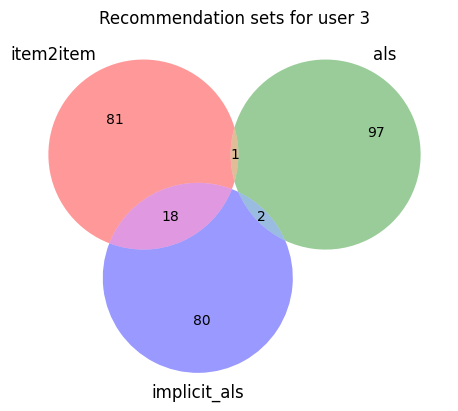

<IPython.core.display.Javascript object>

In [403]:
compare_recommendations(user_index=3, n_recommendations=100)

I noticed that sometimes item2item gives only a handful of meaningful recommendations, after which it recommends items with the least indices. This is because within small datasets there can be a situation when some users interacted with items with which noone else or only a small group of people interacted, leading to small set of neighrest neighbors from which item2item can extract recommendations, which can be smaller in size than requested number of recommendations.